# Seq2Seq Translation using skorch

This notebook demonstrates how to use the code from the [sequence-to-sequence tutorial][1] with skorch!

[1]: http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn
import skorch

from skorch.utils import params_for
from torch.autograd import Variable

In [2]:
%matplotlib inline

### Loading data

We use the same data loading routines as the tutorial but for the
sake of brevity we will leave it out of the notebook and simply
import the code from `data.py`. If you don't have the data already, 
you can download it from http://www.manythings.org/anki/. 

For this notebook to run you need to

- create a `data/` dir
- download http://www.manythings.org/anki/fra-eng.zip
- extract `fra.txt` from `fra-eng.zip` to `data/eng-fra.txt`

In [3]:
import data

In [4]:
input_lang, output_lang, pairs = data.prepareData('eng', 'fra', True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925


In [5]:
print(random.choice(pairs))

['je suis ravie .', 'i m thrilled .']


# Model

The seq2seq model code itself consists of the encoder and the decoder which we can use 1:1 from the example.

## Encoder

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)        
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

## Decoder

In [7]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=data.MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_output, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=-1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=-1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

## Seq2Seq Glue Model

In the original code the encoder and decoder are combined in the training and
evaluation code. We refrain from doing this and define a `Seq2Seq`-model that
unites both and allows us to have a single point of entry and avoids code
duplication for inference and training.

In [8]:
class Seq2Seq(nn.Module):
    def __init__(
        self, 
        encoder, 
        decoder,
        teacher_forcing_ratio=0.5,
        hidden_size=256,
        max_length=data.MAX_LENGTH,
        **kwargs
    ):
        super().__init__()
        self.encoder = encoder(hidden_size=hidden_size, **params_for('encoder', kwargs))
        self.decoder = decoder(hidden_size=hidden_size, **params_for('decoder', kwargs))
        self.max_length = max_length
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
    def forward(self, x, y=None):
        # Encode the input x to the thought vector stored in encoder_outputs.
        encoder_hidden = self.encoder.initHidden().to(x.device)
        encoder_outputs = torch.zeros(self.max_length, self.encoder.hidden_size).to(x.device)
                
        for ei in range(x.size(1)):
            encoder_output, encoder_hidden = self.encoder(x[0, ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0][0]

        use_teacher_forcing = y is not None and random.random() < self.teacher_forcing_ratio
        ys = []
                
        target_length = self.max_length if y is None else y.size(1)
        target_variable = y

        # Decode the thought vector into the target sequence beginning with a 
        # start-of-sentence (SOS) token.
        decoder_input = torch.LongTensor([[data.SOS_token]]).to(x)
        decoder_hidden = encoder_hidden

        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = self.decoder(
                    decoder_input, decoder_hidden, encoder_output, encoder_outputs)
                ys.append(decoder_output)
                decoder_input = target_variable[0, di]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = self.decoder(
                    decoder_input, decoder_hidden, encoder_output, encoder_outputs)
                topv, topi = decoder_output.data.topk(1)
                ni = topi[0][0]

                decoder_input = torch.LongTensor([[ni]]).to(x)

                ys.append(decoder_output)
                if ni == data.EOS_token:
                    break

        return torch.stack(ys, dim=1)

# Training

After defining the necessary components we can prepare everything for the training itself.

### Prerequisites

Some fluff taken 1:1 from the original code.

In [9]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(data.EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    return result.to('cuda' if use_cuda else 'cpu')
    

def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

### Wrapping the seq2seq model in skorch

Now we can wrap our model into a `skorch.NeuralNet` where we 
define how our seq2seq model is trained. For this we need only a few things:

1. A proper loss
2. The training step (data flow in and out of the model)

Since we are dealing with variable length sequences produced
by the model we also have to deal with those in the evaluation step,
namely `predict` and `predict_proba` where we can solve this issue 
by returning a sequence that is padded to a fixed length.

Another extra is that the tutorial uses two separate optimizers for
the encoder and the decoder. We can implement this as well, even though
it does not make a difference with SGD, it might make a difference when
using Adam, for example. We can evaluate this difference by doing a 
grid search over the possible optimizer encoders. For this we will
need a `score()` function as well.

In [10]:
class Trainer(skorch.NeuralNet):
    
    def __init__(
        self, 
        *args, 
        optimizer_encoder=torch.optim.SGD, 
        optimizer_decoder=torch.optim.SGD,
        **kwargs
    ):
        self.optimizer_encoder = optimizer_encoder
        self.optimizer_decoder = optimizer_decoder
        super().__init__(*args, **kwargs)
    
    def initialize_optimizer(self):
        pgroups, kwargs = self.get_params_for_optimizer(
            'optimizer_encoder', self.module_.encoder.parameters())
        self.optimizer_encoder_ = self.optimizer_encoder(*pgroups, **kwargs)
        pgroups, kwargs = self.get_params_for_optimizer(
            'optimizer_decoder', self.module_.decoder.parameters())
        self.optimizer_decoder_ = self.optimizer_decoder(*pgroups, **kwargs)
        return self

    def train_step(self, Xi, yi):
        self.module_.train()
        
        self.optimizer_encoder_.zero_grad()
        self.optimizer_decoder_.zero_grad()

        y_pred = self.infer(Xi, yi)
        loss = self.get_loss(y_pred, yi, X=Xi, training=True)
        loss.backward()
        
        self.optimizer_encoder_.step()
        self.optimizer_decoder_.step()
        
        return {'loss': loss, 'y_pred': y_pred}

    def infer(self, Xi, yi=None):
        Xi = skorch.utils.to_tensor(Xi, device=self.device)
        yi = skorch.utils.to_tensor(yi, device=self.device) if yi is not None else None
        return self.module_(Xi, yi)
    
    def get_loss(self, y_pred, y_true, **kwargs):
        y_true = y_true[:, :y_pred.size(1)]        
        y_pred_flat = y_pred.view(y_pred.size(0) * y_pred.size(1), -1)
        y_true_flat = y_true.view(y_true.size(0) * y_true.size(1))
        
        return super().get_loss(
            y_pred_flat,
            y_true_flat,
            **kwargs)
    
    def _predict(self, X, most_probable=True):
        # return either predicted word probabilities or the most probable 
        # word using argmax.
        y_probas = []
        for yp in self.forward_iter(X, training=False):
            if most_probable:
                pad = np.zeros((yp.size(0), data.MAX_LENGTH))
                pad[:, :yp.size(1)] = skorch.utils.to_numpy(yp.max(-1)[-1])
            else:
                pad = np.zeros((yp.size(0), data.MAX_LENGTH, yp.size(-1)))
                pad[:, :yp.size(1)] = skorch.utils.to_numpy(yp)
            y_probas.append(pad)
        y_proba = np.concatenate(y_probas, 0)
        return y_proba
    
    def predict_proba(self, X):
        return self._predict(X, most_probable=False)
    
    def predict(self, X):
        return self._predict(X, most_probable=True)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        y_true = y_pred.copy()
        
        for i, yi in enumerate(y):
            yi = skorch.utils.to_numpy(yi.squeeze())
            y_true[:, :len(yi)] = yi
        
        return sklearn.metrics.accuracy_score(y_true.flatten(), y_pred.flatten())

### Running the training process

For reasons of practicality we set `n_iters` to a relatively low number so that the training
finishes in a few minutes rather than hours. If you want better accuracy, you just need
to increase this number. The original code uses `n_iters=75000`.

In [11]:
n_iters = 7500
use_cuda = True

We create the training pairs from the first `n_iters` samples. Since the training data is sorted
by length this has the added benefit that we can evaluate shorter (and therefore easier) sequences
fast and increase the difficulty incrementally by increasing `n_iters`.

In [12]:
training_pairs = [variablesFromPair(pairs[i]) for i in range(n_iters)]

We can now instantiate the `Trainer` with the parameters we want to train our model with:

In [13]:
trainer = Trainer(
    criterion=torch.nn.NLLLoss,
    
    # We extended the trainer to support two optimizers
    # but to get the behavior of one optimizer we can 
    # simply use SGD for both, just like in the tutorial.
    optimizer_encoder=torch.optim.SGD,
    optimizer_encoder__lr=0.01,
    optimizer_decoder=torch.optim.SGD,
    optimizer_decoder__lr=0.01,
    
    module=Seq2Seq,
    module__hidden_size=256,

    module__encoder=EncoderRNN,
    module__encoder__input_size=input_lang.n_words,
    
    module__decoder=AttnDecoderRNN,
    module__decoder__output_size=output_lang.n_words,
    module__decoder__dropout_p=0.1,
    
    # We have no internal validation.
    train_split=None,
    
    # The decoding code is not meant to be batched
    # so we have to deal with a batch size of 1 for
    # both training and validation/prediction.
    iterator_train__batch_size=1,
    iterator_valid__batch_size=1,
    
    # We are training only one large epoch.
    max_epochs=1,
    
    # Training takes a long time, add a progress bar
    # to see how far in we are. Since we are doing 
    # grid search with cross-validation splits and the
    # total amount of batches_per_epoch varies, we set
    # the batches_per_epoch method to 'auto', instead 
    # of the default, 'count'.
    callbacks=[
        skorch.callbacks.ProgressBar(batches_per_epoch='auto'),
    ],
    
    device=('cuda' if use_cuda else 'cpu'),
)

Now we just create our X/y pairs, define our parameters for the grid search and run `.fit()` to find the best parametrization of our `Trainer` instance.

In [14]:
X = np.array([n[0].data for n in training_pairs], dtype=object)
y = np.array([n[1].data for n in training_pairs], dtype=object)

In [15]:
from sklearn.model_selection import GridSearchCV

We use a grid search to determine whether it makes sense to use different optimizers for the encoder and the decoder, in this case we test between Adam and SGD. We expect it to run for `3 * 4 = 12` training iterations as we are using the default 3-fold CV split and have 4 parameter combinations:

In [16]:
params = {
    'optimizer_encoder': [torch.optim.SGD, torch.optim.Adam],
    'optimizer_decoder': [torch.optim.SGD, torch.optim.Adam],
}

In [17]:
gs = GridSearchCV(trainer, params)

In [18]:
%pdb on
gs.fit(X, y)

Automatic pdb calling has been turned ON


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


  epoch    train_loss       dur
-------  ------------  --------
      1        3.2864  130.2924


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


  epoch    train_loss       dur
-------  ------------  --------
      1        3.0170  123.9097


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


  epoch    train_loss       dur
-------  ------------  --------
      1        2.7005  116.5283


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


  epoch    train_loss       dur
-------  ------------  --------
      1        3.0571  132.8406


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


  epoch    train_loss       dur
-------  ------------  --------
      1        2.8227  126.8780


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


  epoch    train_loss       dur
-------  ------------  --------
      1        2.5147  120.3536


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


  epoch    train_loss       dur
-------  ------------  --------
      1        7.3987  134.3116


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


  epoch    train_loss       dur
-------  ------------  --------
      1        8.0080  131.6806


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


  epoch    train_loss       dur
-------  ------------  --------
      1        7.5580  126.8411


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


  epoch    train_loss       dur
-------  ------------  --------
      1       12.5318  154.2361


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


  epoch    train_loss       dur
-------  ------------  --------
      1       11.7451  142.4930


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


  epoch    train_loss       dur
-------  ------------  --------
      1       11.4114  132.3407


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


  epoch    train_loss       dur
-------  ------------  --------
      1        2.8116  199.1263


GridSearchCV(cv=None, error_score='raise',
       estimator=<class '__main__.Trainer'>[uninitialized](
  module=<class '__main__.Seq2Seq'>,
  module__decoder=<class '__main__.AttnDecoderRNN'>,
  module__decoder__dropout_p=0.1,
  module__decoder__output_size=2925,
  module__encoder=<class '__main__.EncoderRNN'>,
  module__encoder__input_size=4489,
  module__hidden_size=256,
),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'optimizer_encoder': [<class 'torch.optim.sgd.SGD'>, <class 'torch.optim.adam.Adam'>], 'optimizer_decoder': [<class 'torch.optim.sgd.SGD'>, <class 'torch.optim.adam.Adam'>]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

So let's look at the best parameters:

In [19]:
gs.best_params_

{'optimizer_decoder': torch.optim.sgd.SGD,
 'optimizer_encoder': torch.optim.sgd.SGD}

And there we have it: Using two separate optimizers is irrelevant for the set of parameters we evaluated. The best is to just use SGD in for both the encoder and decoder, or, as SGD is stateless, just use a single SGD for both.

We can now use the estimator with the best configuration to observe how well it translates, but first, let's save the model for later use:

In [20]:
ef = gs.best_estimator_

In [21]:
ef.save_params(f_params='model.pt')

# Results

### Plot Training Loss

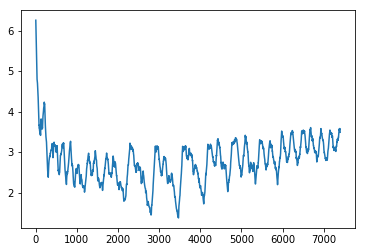

In [22]:
N = 100
plt.plot(np.convolve(ef.history[:,'batches',:,'train_loss'][0], np.ones((N,))/N, mode='valid'))

### Evaluate performance on the training set

In [23]:
eval_data = X[:10]
pred = ef.predict(eval_data)
pred_proba = ef.predict_proba(eval_data)

In [24]:
for (sent_in, sent_out) in zip(eval_data, pred):
    print([input_lang.index2word.get(w[0], '???') for w in sent_in])
    print([output_lang.index2word[w] for w in sent_out])
    print()

['???', '???', '???', '???', '???']
['i', 'm', 'a', 'to', 'to', '.', '.', 'EOS', 'SOS', 'SOS']

['???', '???', '???', '???', '???']
['i', 'm', 'a', 'to', 'to', '.', '.', 'EOS', 'SOS', 'SOS']

['???', '???', '???', '???']
['i', 'm', 'a', 'to', 'to', '.', '.', 'EOS', 'SOS', 'SOS']

['???', '???', '???', '???', '???']
['i', 'm', 'a', 'to', 'to', '.', '.', 'EOS', 'SOS', 'SOS']

['???', '???', '???', '???', '???']
['i', 'm', 'a', 'to', 'to', '.', '.', 'EOS', 'SOS', 'SOS']

['???', '???', '???', '???', '???', '???']
['i', 'm', 'a', 'to', 'to', '.', '.', 'EOS', 'SOS', 'SOS']

['???', '???', '???', '???', '???']
['i', 'm', 'a', 'to', 'to', '.', '.', 'EOS', 'SOS', 'SOS']

['???', '???', '???', '???', '???']
['i', 'm', 'a', 'to', 'to', '.', '.', 'EOS', 'SOS', 'SOS']

['???', '???', '???', '???', '???']
['i', 'm', 'a', 'to', 'to', '.', '.', 'EOS', 'SOS', 'SOS']

['???', '???', '???', '???', '???']
['i', 'm', 'a', 'to', 'to', '.', '.', 'EOS', 'SOS', 'SOS']

